In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import random
import gc
import re
import spacy
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import torch
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [29]:
essays = pd.read_csv('essay_dataset.csv')
essays.sort_values(by=['EssayScore'], inplace=True)
essays.head()

,Unnamed: 0,EssayTopic,EssayBody,S1,S2,S3,EssayScore
60,60,What kind of climate do you prefer to live in?...,"Human live in the earth, as result they have ...",5.0,5.5,5.0,5.0
55,55,What kind of climate do you prefer to live in?...,If I want to choose a climate for living in t...,5.0,5.0,5.0,5.0
31,31,It is possible to be single for all your life ...,As long as the world around us has become mod...,5.0,5.0,5.0,5.0
40,40,Money can solve all problems. Do you agree or ...,"These days, people’s life is more complex, ha...",5.0,5.0,5.0,5.0
10,10,What kind of climate do you prefer to live in?...,If I want to choose a climate for living in t...,5.0,5.0,5.0,5.0


In [30]:
essays.describe()

,Unnamed: 0,S1,S2,S3,EssayScore
count,68.00000,68.000000,68.000000,68.000000,68.000000
mean,33.50000,7.470588,7.551471,7.477941,7.522059
std,19.77372,1.218276,1.149756,1.107754,1.144206
min,0.00000,5.000000,5.000000,5.000000,5.000000
25%,16.75000,6.500000,6.500000,6.875000,6.500000
50%,33.50000,8.000000,8.000000,8.000000,8.000000
75%,50.25000,8.500000,8.500000,8.500000,8.500000
max,67.00000,9.000000,9.000000,9.000000,9.000000


<AxesSubplot:>

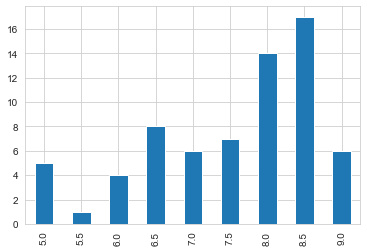

In [31]:
essays['EssayScore'].value_counts().sort_index().plot(kind='bar')

def new_label(value):
    if value > 8:
        return 'Band-8'
    elif value > 6.5:
        return 'Band-7'
    else:
        return 'Band-6'

In [32]:
def new_label(value):
    if value > 8:
        return 'Band-8'
    elif value > 7:
        return 'Band-7'
    else:
        return 'Band-6'

In [33]:
essays['EssayScore'] = essays['EssayScore'].map(new_label)
essays.head()

,Unnamed: 0,EssayTopic,EssayBody,S1,S2,S3,EssayScore
60,60,What kind of climate do you prefer to live in?...,"Human live in the earth, as result they have ...",5.0,5.5,5.0,Band-6
55,55,What kind of climate do you prefer to live in?...,If I want to choose a climate for living in t...,5.0,5.0,5.0,Band-6
31,31,It is possible to be single for all your life ...,As long as the world around us has become mod...,5.0,5.0,5.0,Band-6
40,40,Money can solve all problems. Do you agree or ...,"These days, people’s life is more complex, ha...",5.0,5.0,5.0,Band-6
10,10,What kind of climate do you prefer to live in?...,If I want to choose a climate for living in t...,5.0,5.0,5.0,Band-6


<AxesSubplot:>

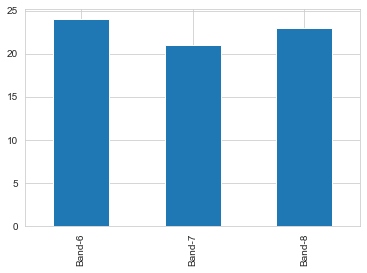

In [34]:
essays['EssayScore'].value_counts().sort_index().plot(kind='bar')

In [35]:
seqlen = essays['EssayBody'].apply(lambda x: len(x.split()))

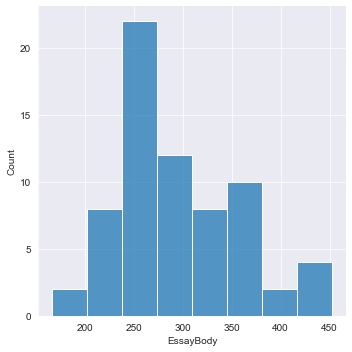

In [36]:
sns.set_style('darkgrid')
plt.figure.Figure(figsize=(16,10))
sns.displot(seqlen)

In [37]:
possible_labels = essays.EssayScore.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'Band-6': 0, 'Band-7': 1, 'Band-8': 2}

In [38]:
essays['EssayScore'] = essays.EssayScore.replace(label_dict)
essays = essays.astype({'EssayScore': int})
essays.head()

,Unnamed: 0,EssayTopic,EssayBody,S1,S2,S3,EssayScore
60,60,What kind of climate do you prefer to live in?...,"Human live in the earth, as result they have ...",5.0,5.5,5.0,0
55,55,What kind of climate do you prefer to live in?...,If I want to choose a climate for living in t...,5.0,5.0,5.0,0
31,31,It is possible to be single for all your life ...,As long as the world around us has become mod...,5.0,5.0,5.0,0
40,40,Money can solve all problems. Do you agree or ...,"These days, people’s life is more complex, ha...",5.0,5.0,5.0,0
10,10,What kind of climate do you prefer to live in?...,If I want to choose a climate for living in t...,5.0,5.0,5.0,0


In [39]:

X_train, X_val, y_train, y_val = train_test_split(essays.index.values, 
                                                  essays.EssayScore.values, 
                                                  test_size=0.20, 
                                                  random_state=42, 
                                                  stratify=essays.EssayScore.values)

essays['data_type'] = ['not_set']*essays.shape[0]

essays.loc[X_train, 'data_type'] = 'train'
essays.loc[X_val, 'data_type'] = 'val'

essays.groupby(['EssayScore', 'data_type']).count()

Unnamed: 0  EssayTopic  EssayBody  S1  S2  S3
EssayScore data_type                                               
0          train              19          19         19  19  19  19
           val                 5           5          5   5   5   5
1          train              17          17         17  17  17  17
           val                 4           4          4   4   4   4
2          train              18          18         18  18  18  18
           val                 5           5          5   5   5   5

In [40]:
essays.dtypes

Unnamed: 0      int64
EssayTopic     object
EssayBody      object
S1            float64
S2            float64
S3            float64
EssayScore      int64
data_type      object
dtype: object

In [41]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    essays[essays.data_type=='train'].EssayBody.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='max_length', 
    max_length = 318,
    truncation=True,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    essays[essays.data_type=='val'].EssayBody.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='max_length', 
    max_length = 318,
    truncation=True,
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(essays[essays.data_type=='train'].EssayScore.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(essays[essays.data_type=='val'].EssayScore.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

_______

_________

In [42]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [43]:


batch_size = 1

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [48]:
dataset_val

In [18]:




optimizer = AdamW(model.parameters(),
                  lr=3e-5, 
                  eps=1e-8)
                  
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


from transformers import AdamW, get_linear_schedule_with_warmup



optimizer = torch.optim.Adam(model.parameters(),
                  lr=1e-3,
                  eps=1e-8)

epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

from transformers.optimization import Adafactor, AdafactorSchedule

optimizer = Adafactor(model.parameters(), scale_parameter=True, relative_step=True, warmup_init=True, lr=None)

epochs = 10

scheduler = AdafactorSchedule(optimizer)

In [24]:



def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cpu


In [21]:


seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


In [19]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [23]:


gc.collect()

torch.cuda.empty_cache()

In [24]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'data_volume/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/54 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.1003459416053913
Validation loss: 1.0911068235124861
F1 Score (Weighted): 0.3174603174603175


Epoch 2:   0%|          | 0/54 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.0030735394469015
Validation loss: 0.8250943379742759
F1 Score (Weighted): 0.4693877551020408


Epoch 3:   0%|          | 0/54 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.9710028397816198
Validation loss: 0.6448051386645862
F1 Score (Weighted): 0.8398268398268397


Epoch 4:   0%|          | 0/54 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.7429846806658639
Validation loss: 0.5844805517366954
F1 Score (Weighted): 0.7736549165120594


Epoch 5:   0%|          | 0/54 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.647342998534441
Validation loss: 0.6297583042510918
F1 Score (Weighted): 0.7142857142857144


In [25]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load('model.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: Band-6
Accuracy: 5/5

Class: Band-7
Accuracy: 2/4

Class: Band-8
Accuracy: 5/5

